In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import regionmask
import pandas as pd
from datetime import datetime, timedelta
import utils

In [2]:
months = ['jan']#,'apr','jul','oct']

In [3]:
ds_delta = {}
ds_base = {}
ds_emisbase = {}
ds_emispulse = {}
ds_conc2x = {}
ds_emis2x = {}
for month in months:
    ds_delta[month] = {}
    ds_base[month] = {}
    ds_emisbase[month] = {}
    ds_emispulse[month] = {}
    ds_conc2x[month] = {}
    ds_emis2x[month] = {}

In [5]:
for month in months:

    ds_delta[month]['global'] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/BC_sustained/sust_2016_{month}_BC/OutputDir/GEOSChem.AerosolMass.2016*', combine = 'by_coords')

    ds_base[month]['global'] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/BC_base/base_2016_{month}_BC/OutputDir/GEOSChem.AerosolMass.2016*', combine = 'by_coords')

    ds_emisbase[month]['global'] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/BC_base/base_2016_{month}_BC/OutputDir/HEMCO_diagnostics.2016*', combine = 'by_coords')

    ds_emispulse[month]['global'] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/BC_sustained/sust_2016_{month}_BC/OutputDir/HEMCO_diagnostics.2016*.nc', combine = 'by_coords')

    #ds_conc2x[month] = xr.open_mfdataset('../GCrundirs/IRF_runs/2x_jan_BC/OutputDir/GEOSChem.AerosolMass.2016*.nc4', combine = 'by_coords')
    #ds_emis2x[month] = xr.open_mfdataset('../GCrundirs/IRF_runs/2x_jan_BC/OutputDir/HEMCO_diagnostics.2016*', combine = 'by_coords')

## Add in the area and dz

In [6]:
### import the regions we are interested in ###
ar6_coal_location = pd.read_csv('ar6_coal_location.csv', index_col = 'number').to_dict()['acronym']

In [7]:
height = pd.read_excel('gc_altitude.xlsx')

In [8]:
height_ds = height.diff().dropna().to_xarray().rename({'index':'lev'})
height_ds['lev'] = ds_base['jan']['global']['lev']
height_ds = height_ds.rename({'altitude':'dz'}) 
height_ds['dz']*=1e3


In [9]:
full_loc = list(ar6_coal_location.values())
full_loc.append('global')

In [10]:
for month in months:
    ds_emisbase[month]['global'] = xr.merge([ds_emisbase[month]['global'], height_ds], join = 'inner')
    ds_emispulse[month]['global'] = xr.merge([ds_emispulse[month]['global'], height_ds], join = 'inner')
    ds_base[month]['global'] = xr.merge([ds_base[month]['global'], height_ds], join = 'inner')
    ds_delta[month]['global'] = xr.merge([ds_delta[month]['global'], height_ds], join = 'inner')
    #ds_conc2x[month] = xr.merge([ds_conc2x[month], height_ds], join = 'inner')
    #ds_emis2x[month] = xr.merge([ds_emis2x[month], height_ds], join = 'inner')

In [11]:
for ds in [ds_emispulse, ds_emisbase]:#,ds_emis2x]:
    for month in months:
         utils.combine_BC(ds[month]['global'])

## Regional Comparison

In [12]:
#### create a mask ####
regions = regionmask.defined_regions.ar6.land

for r in ar6_coal_location:
    mask = regions.mask(ds_delta['jan']['global'], lon_name = 'lon', lat_name = 'lat')
    contiguous_mask = ~np.isnan(mask)& (mask == r)
    for month in months:
        #### mask our population dataset ####
        ds_emisbase[month][ar6_coal_location[r]] = ds_emisbase[month]['global'].where(contiguous_mask)
        ds_emispulse[month][ar6_coal_location[r]] = ds_emispulse[month]['global'].where(contiguous_mask)
        ds_base[month][ar6_coal_location[r]] = ds_base[month]['global'].where(contiguous_mask)
        ds_delta[month][ar6_coal_location[r]] = ds_delta[month]['global'].where(contiguous_mask)

In [13]:
ds_delta_r = {}
ds_base_r = {}
ds_emisbase_r = {}
ds_emispulse_r = {}
ds_conc2x_r = {}
ds_emis2x_r = {}
for month in months:
    ds_delta_r[month] = {}
    ds_base_r[month] = {}
    ds_emisbase_r[month] = {}
    ds_emispulse_r[month] = {}
    ds_conc2x_r[month] = {}
    ds_emis2x_r[month] = {}

In [14]:
for r in full_loc:
    for month in months:
        #### mask our population dataset ####
        ds_emisbase_r[month][r] = ds_emisbase[month][r].fillna(0)
        ds_emispulse_r[month][r] = ds_emispulse[month][r].fillna(0)
        ds_base_r[month][r] = ds_base[month][r].fillna(0)
        ds_delta_r[month][r] = ds_delta[month][r].fillna(0)

In [15]:
Ndt = 90
dt = 1 #days
t_range = np.arange(0., dt*Ndt, dt)
Δt = 1


## Find G for each month

In [21]:
GC_out = {}
f0 = {}
for month in months:
    GC_out[month] = {}
    f0[month] = {}

In [26]:
for month in months:
    for r in full_loc:
        #ds_GF[month]['f'] = (utils.global_w_mean(ds_emis2x, 'EmisBC_Total') - utils.global_w_mean(ds_emisbase, 'EmisBC_Total'))
        #ds_GF[month]['f']= ds_GF[month]['f'].assign_coords(time = np.arange(0,len(f['time']))) #inputting a x2 until we get our doubled emissions as daily data
        GC_out[month][r]= (utils.global_w_mean(ds_delta_r[month][r], 'AerMassBC') - 
             utils.global_w_mean(ds_base_r[month][r], 'AerMassBC'))
        GC_out[month][r]= GC_out[month][r].assign_coords(time = np.arange(0,len(GC_out[month][r]['time'])))

        f0[month][r] = (utils.global_w_mean(ds_emispulse_r[month][r], 'EmisBC_Total') - 
              utils.global_w_mean(ds_emisbase_r[month][r], 'EmisBC_Total')).isel(time = 0)

In [21]:
GC_avg = {}
for r in full_loc:
    GC_avg[r] = ((GC_out['jan'][r]+GC_out['apr'][r]+GC_out['jul'][r]+GC_out['oct'][r])/4)

KeyError: 'apr'

In [ ]:
for r in full_loc:
    ((GC_out['jan'][r]+GC_out['apr'][r]+GC_out['jul'][r]+GC_out['oct'][r])/4).plot()

In [ ]:
((GC_out['jan']['ENA']+GC_out['apr']['ENA']+GC_out['jul']['ENA']+GC_out['oct']['ENA'])/4).plot()

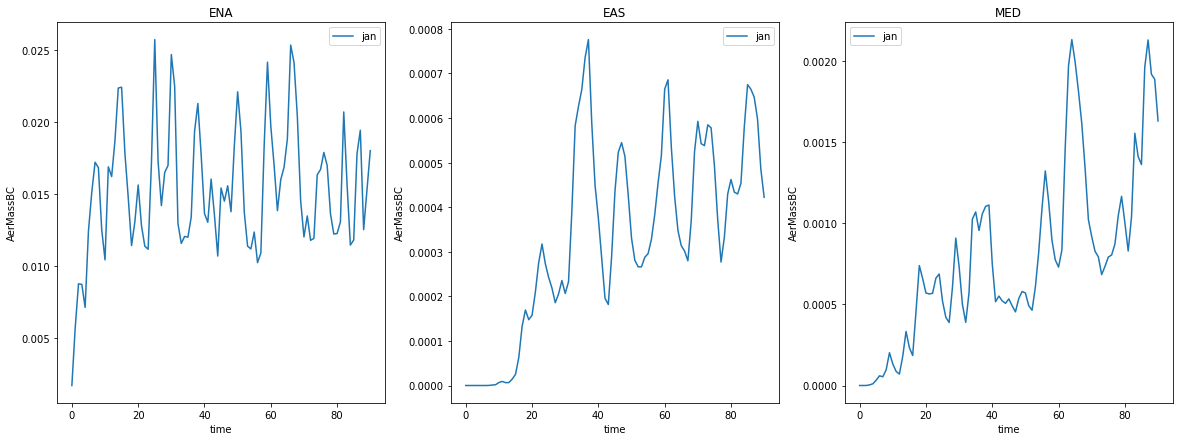

In [27]:
fig = plt.figure(figsize=(20,7))
for idx, r in enumerate(['ENA','EAS','MED']):
    ax = fig.add_subplot(1,3,idx+1)
    for idx, month in enumerate(months):
        GC_out[month][r].plot(label = month, ax = ax)
        plt.legend()
        plt.title(r)
        #plt.ylim(0.00011,0.00017)
plt.savefig('figures/regions_months_G_zoomed.png', bbox_inches = 'tight')

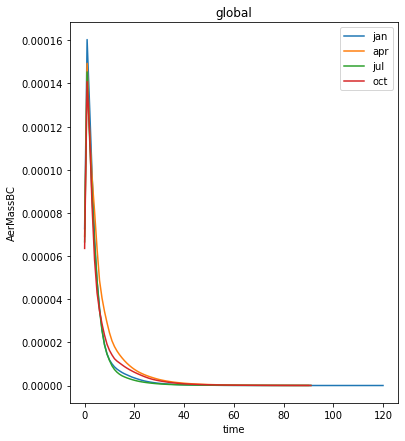

In [26]:
fig = plt.figure(figsize=(20,7))
for idx, r in enumerate(['global']):
    ax = fig.add_subplot(1,3,idx+1)
    for idx, month in enumerate(months):
        GC_out[month][r].plot(label = month, ax = ax)
        plt.legend()
        plt.title(r)
        #plt.ylim(0.00011,0.00017)
plt.savefig('figures/regions_months_G_global.png', bbox_inches = 'tight')

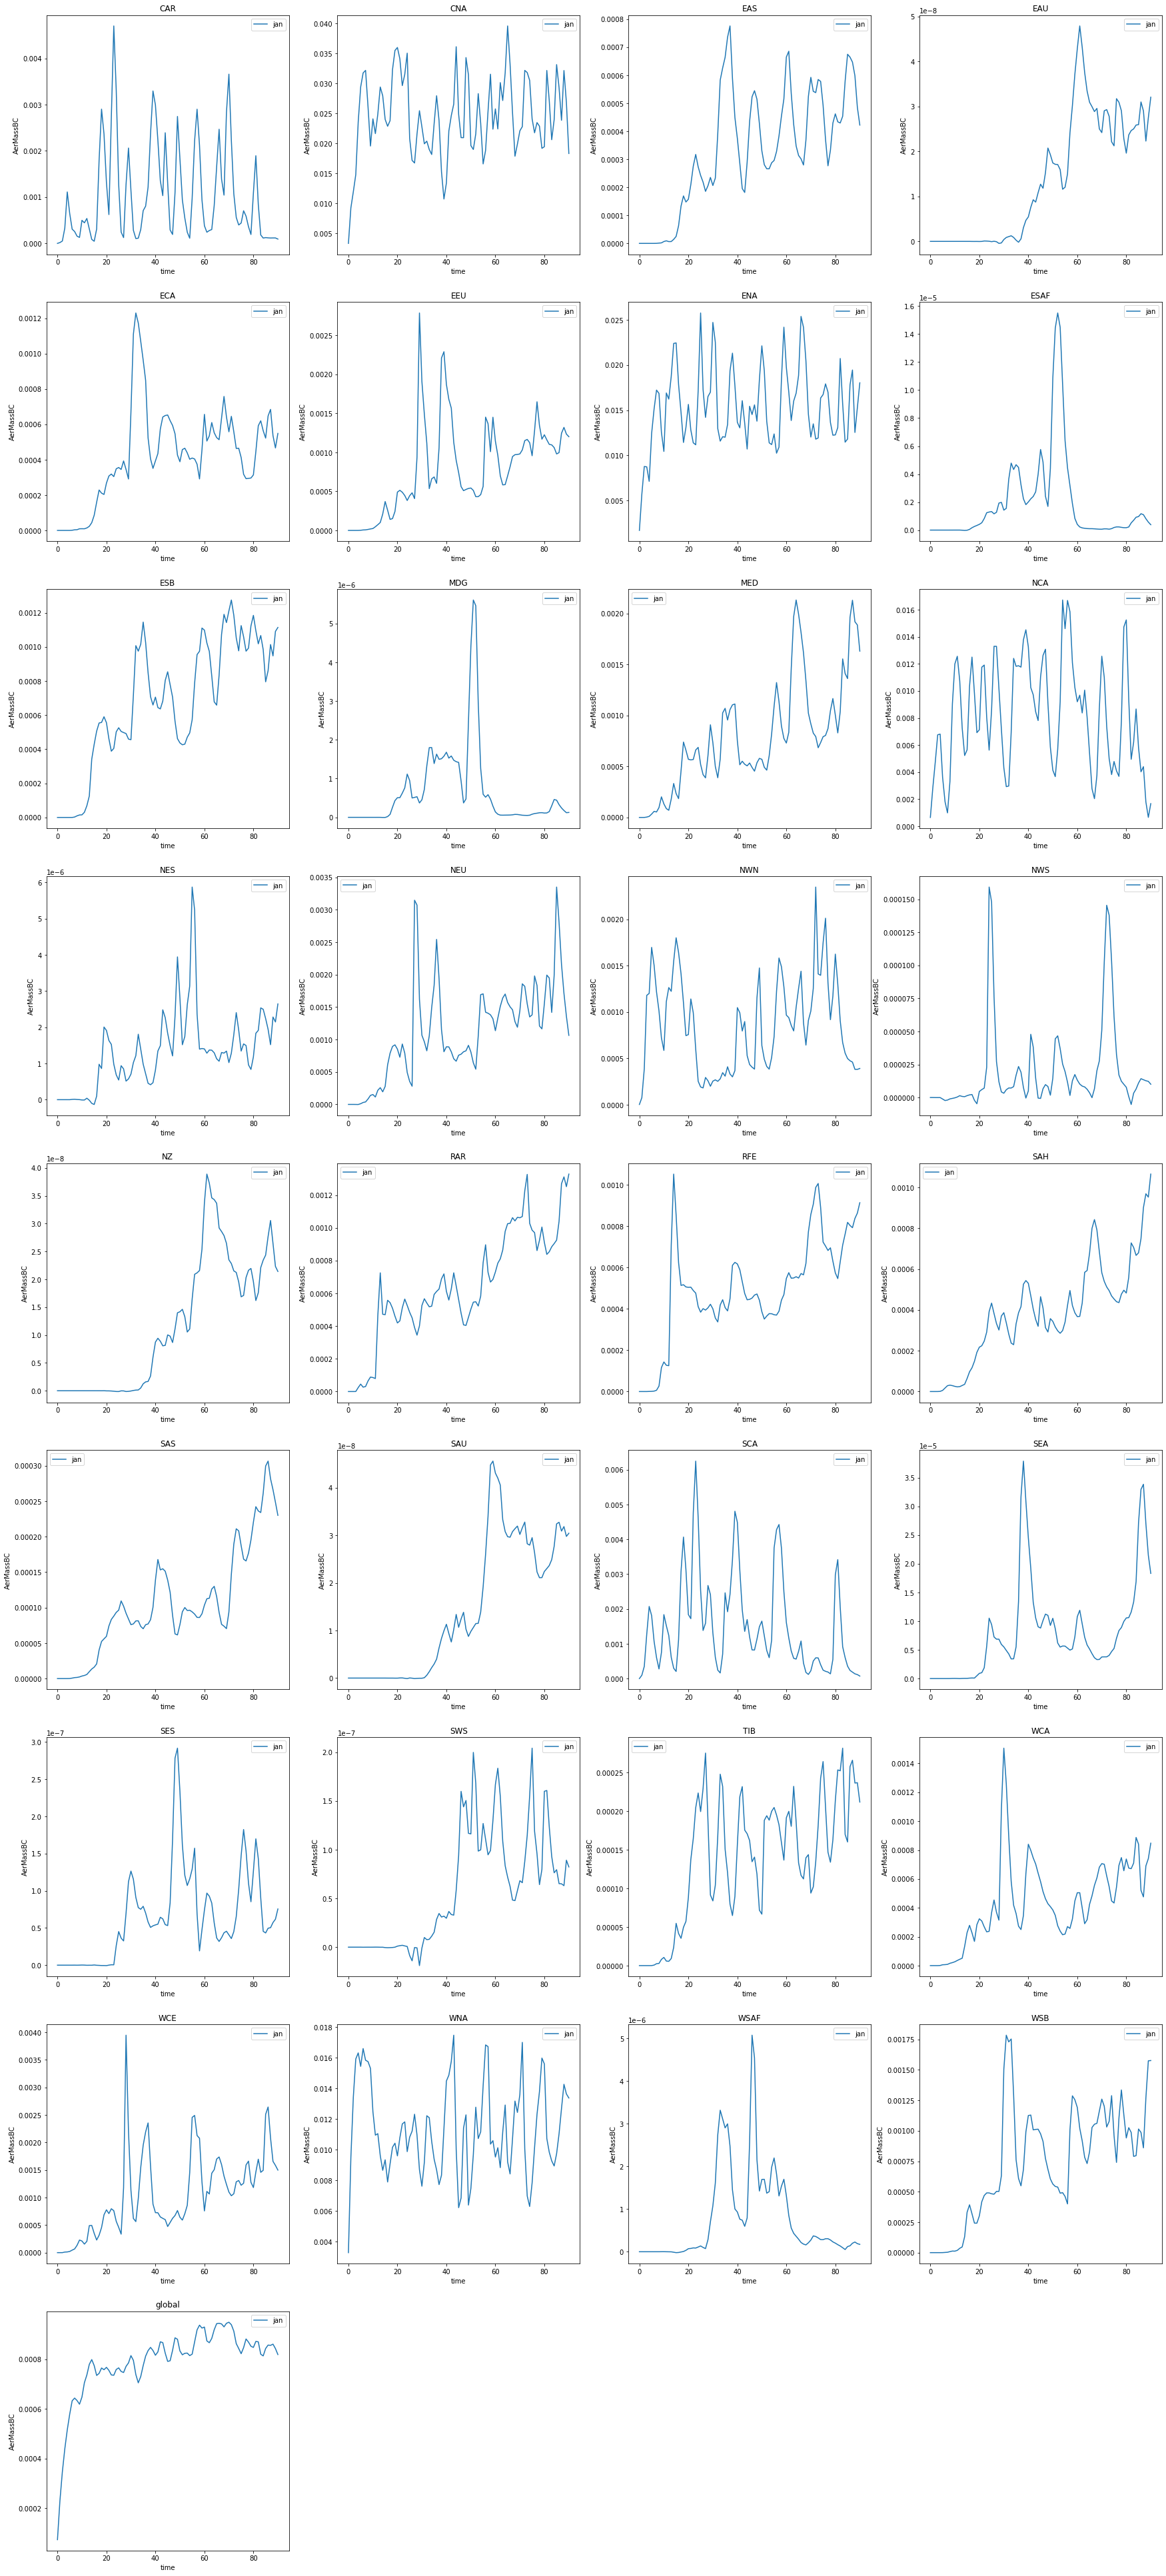

In [28]:
fig = plt.figure(figsize=(30,70))
for idx, r in enumerate(full_loc):
    ax = fig.add_subplot(9,4,idx+1)
    for idx, month in enumerate(months):
        GC_out[month][r].plot(label = month, ax = ax)
        plt.legend()
        plt.title(r)
        #plt.ylim(0.00011,0.00017)
plt.savefig('figures/regions_months_G.png', bbox_inches = 'tight')